In [1]:
!pip install pyforest
from pyforest import *
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
import datetime, pickle, copy, warnings
from pandas import DataFrame, concat
import seaborn
import glob
import pandas.testing as tm
from functools import reduce
from pandas import DataFrame, merge, concat
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from joblib import Parallel, delayed
import seaborn as sns
import time
from sklearn.preprocessing import MaxAbsScaler
import scipy.linalg
import decimal
!pip install scikit-plot
import scikitplot
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.ticker as mtick
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from yellowbrick.classifier import ClassificationReport
from sklearn.decomposition import PCA, KernelPCA
from numpy import where, meshgrid, arange, hstack
from mlxtend.plotting import plot_decision_regions
from sklearn.manifold import TSNE
from sklearn.decomposition import MiniBatchDictionaryLearning
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import plotly.express as px
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold,StratifiedKFold, RepeatedStratifiedKFold, cross_val_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV,SelectPercentile,mutual_info_classif, SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from numpy import mean, std
!pip install tscv
!pip install termcolor

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
df = pd.read_csv("july_futures_1min.csv")
df.set_index('timestamp', inplace=True)
df.sort_index(ascending=True, inplace=True)
df.index = pd.to_datetime(df.index)

ts = df.copy()

ts = df[['es_close', 'es_open', 'es_high', 'es_low', 'es_countp', 'es_countg']].copy()
ts.loc[:,'volume'] = ts['es_countp'] + ts['es_countg']
ts = ts[['es_close', 'es_open', 'es_high', 'es_low', 'volume']]
ts = ts[ts['volume'] > 0]
#d = d.reset_index()
ts.index = pd.to_datetime(ts.index) # setting index as datetime
ts = ts.resample('15min').mean() # resampling with 15 min frequency
ts.sort_index(ascending=True, inplace=True) # soring ascending order
ts.drop_duplicates(inplace=True) # dropping duplicates if any
ts.fillna(method='pad', inplace=True) # filling NaN values using bcak-fill method
#print(ts)

# Create the new lagged DataFrame
features = pd.DataFrame(index=ts.index)
features["current_period"] = ts["es_close"].copy()
features["Volume"] = ts["volume"].copy()
#features['o-c'] = (ts['es_open'] - ts['es_close']).copy()
#features['h-l'] = (ts['es_high'] - ts['es_low']).copy()
    
lags = 5
# Create the shifted lag series of prior trading period close values
for i in range(0, lags):
    features["Lag%s" % str(i+1)] = ts["es_close"].shift(i+1)
        
# Create the returns DataFrame
tsret = DataFrame(index=features.index)
tsret["volume"] = features["Volume"]
tsret["current_period"] = features["current_period"].pct_change()*100.0
#tsret['o-c'] = features['o-c'].copy()
#tsret['h-l'] = features['h-l'].copy()
    
# If any of the values of percentage returns equal zero, setting them to
# a small number (stops issues with QDA model)
for i,x in enumerate(tsret["current_period"]):
    if (abs(x) < 0.0001):
        tsret["current_period"][i] = 0.0001
            
# Create the lagged percentage returns columns
for i in range(0, lags):
    tsret["Lag%s" % str(i+1)] = features["Lag%s" % str(i+1)].pct_change()*100.0
# Create the "Direction" column (+1 or -1) indicating an up/down day
tsret["Direction"] = np.sign(tsret["current_period"])

SPret = tsret.dropna().copy()
    # Use the prior two days of returns as predictor
    # values, with direction as the response
x = SPret[["Lag1","Lag2"]]
y = SPret["Direction"]

"""
predictor is set to use only the first two lags. so, 
implicitly stating to the classifier that the further lags are of less predictive value
"""
    
# # Create training and test sets
from tscv import GapKFold
gkcv = GapKFold(n_splits=3, gap_before=2, gap_after=1)

"""
Introduced gaps between the training and test set to mitigate the temporal dependence.
Here the split function splits the data into Kfolds. 
The test sets are untouched, while the training sets get the gaps removed
"""

for tr_index, te_index in gkcv.split(x, y):
    xTrain, xTest = x.values[tr_index], x.values[te_index];
    yTrain, yTest = y.values[tr_index], y.values[te_index];
        #splits.append(('TRAIN:', x_tr, 'TEST:', x_te))
    
#print('Observations: %d' % (len(xTrain) + len(xTest)))
#print('Training Observations: %d' % (len(xTrain)))
#print('Testing Observations: %d' % (len(xTest))) 

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

# Create the (parametrised) models
print("Hit Rates/Confusion Matrices:\n")
models = [("LR", LogisticRegression()),
          ("LDA", LinearDiscriminantAnalysis()),
          ("QDA", QuadraticDiscriminantAnalysis()),
          ("LSVC", LinearSVC()),
          ("RSVM", SVC(C=1000000.0, cache_size=200, class_weight=None,
                       coef0=0.0, degree=3, gamma=0.0001, kernel='rbf',
                       max_iter=-1, probability=False, random_state=None,
                       shrinking=True, tol=0.001, verbose=False)),
          ("RF", RandomForestClassifier(
              n_estimators=1000, criterion='gini',
              max_depth=None, min_samples_split=2,
              min_samples_leaf=1, max_features='auto',
              bootstrap=True, oob_score=False, n_jobs=1,
              random_state=None, verbose=0))]
# iterate over the models
for m in models:
    # Train each of the models on the training set
    m[1].fit(xTrain, yTrain)
    # array of predictions on the test set
    pred = m[1].predict(xTest)
    # hit-rate and the confusion matrix for each model
    print("%s:\n%0.3f" % (m[0], m[1].score(xTest, yTest)))
    print("%s\n" % confusion_matrix(pred, yTest))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hit Rates/Confusion Matrices:

LR:
0.583
[[125  76]
 [207 271]]

LDA:
0.595
[[147  90]
 [185 257]]

QDA:
0.552
[[116  88]
 [216 259]]

LSVC:
0.592
[[145  90]
 [187 257]]

RSVM:
0.589
[[143  90]
 [189 257]]

RF:
0.526
[[157 147]
 [175 200]]



In [3]:
lda = LinearDiscriminantAnalysis().fit(x,y)
SPret['Predicted_Signal'] = lda.predict(x)
ts = ts[['es_close']].copy()
SPret['Close'] = ts.es_close
SPret = SPret[['Close', 'Direction']]
SPret['SP_Returns'] = (np.log(SPret['Close'] / SPret['Close'].shift(1))).copy()

<IPython.core.display.Javascript object>

@sarit:

Portfolio Value = 1e6 # 1,000,000 USD
ConfidenceInterval = 0.99 # 99% confidence interval
ValueatRisk (VaR): $2182.65


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Sharpe Ratio: 2.4769459537742402e-05


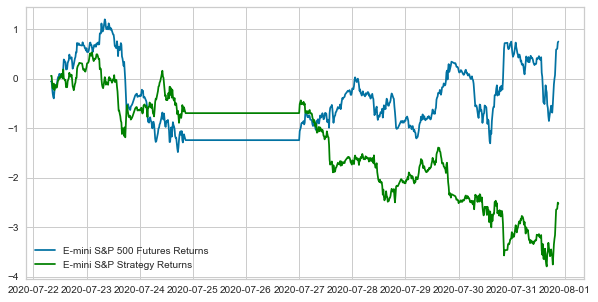

In [4]:
SPret['Predicted_Signal'] = lda.predict(x)
from __future__ import print_function
import datetime
import numpy as np
from scipy.stats import norm

print('@sarit:'); print()
def var_cov_var(P, c, mu, sigma):
    """
    Variance-Covariance calculation of daily Value-at-Risk
    using confidence level c, with mean of returns mu
    and standard deviation of returns sigma, on a portfolio
    of value P.
    """
    alpha = norm.ppf(1-c, mu, sigma)
    return P - P*(alpha + 1)

if __name__ == "__main__":
    #SPret["rets"] = SPret["Close"].pct_change()
    P = 1e6 # 1,000,000 USD
    c = 0.99 # 99% confidence interval
    mu = np.mean(SPret["SP_Returns"])
    sigma = np.std(SPret["SP_Returns"])
    var = var_cov_var(P, c, mu, sigma)
    print('Portfolio Value = 1e6 # 1,000,000 USD')
    print("ConfidenceInterval = 0.99 # 99% confidence interval")
    print("ValueatRisk (VaR): $%0.2f" % var); 

def calculate_return(SPret, split_value, symbol):
    cum_return = SPret[split_value:]['%s_Returns' % symbol].cumsum() * 100
    SPret['Strategy_Returns'] = (SPret['%s_Returns' % symbol] * SPret['Predicted_Signal'].shift(1)).copy()
    return cum_return

def calculate_strategy_return(SPret, split_value, symbol):
    cum_strategy_return = SPret[split_value:]['Strategy_Returns'].cumsum() * 100
    return cum_strategy_return

cum_return = calculate_return(SPret, split_value = len(xTrain), symbol='SP')
cum_strategy_return = calculate_strategy_return(SPret, split_value = len(xTrain), symbol='SP')

def plot_chart(cum_return, cum_strategy_return, symbol):
    plt.figure(figsize=(10, 5))
    plt.plot(cum_return, label='%s Returns' % symbol)
    plt.plot(cum_strategy_return, label='E-mini S&P Strategy Returns', color = 'green')
    plt.legend()
    
plot_chart(cum_return, cum_strategy_return, symbol='E-mini S&P 500 Futures')

# logarithmic returns using the closing price 
returns = np.log(SPret['Close'] / SPret['Close'].shift(1))
volatility = returns.std() * np.sqrt(252*6.5*60*15) # 15 min frequency

"""
Sharpe ratio for the strategy based on a
benchmark of zero (i.e. no risk-free rate information).
periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60)
"""
sharpe_ratio = (returns.mean()) / volatility 

"""
if assumed the risk-free rate of return as 5%, sharpe value can be calculated using:
(returns.mean() - 0.05) / volatility
"""
print("Sharpe Ratio:", sharpe_ratio)

@Sarit:
Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  Total/PnL->  0

Open/PnL->  0  Closed/PnL->  0  

SELL  10  @  3122.5666666666666 Position =>  -320
Open/PnL->  303.4166666668898  Closed/PnL->  491.7499999999418  Total/PnL->  795.1666666668316

Open/PnL->  658.0833333334886  Closed/PnL->  491.7499999999418  Total/PnL->  1149.8333333334303

Open/PnL->  490.08333333360497  Closed/PnL->  491.7499999999418  Total/PnL->  981.8333333335468

SELL  10  @  3124.9083333333333 Position =>  -330
Open/PnL->  -445.91666666639867  Closed/PnL->  491.7499999999418  Total/PnL->  45.83333333354312

SELL  10  @  3130.0 Position =>  -340
Open/PnL->  -2126.1666666665496  Closed/PnL->  491.7499999999418  Total/PnL->  -1634.4166666666079

SELL  10  @  3133.7916666666665 Position =>  -350
Open/PnL->  -3415.3333333330693  Closed/PnL->  491.7499999999418  Total/PnL->  -2923.5833333331275

Open/PnL->  -3660.333333333165  Closed/PnL->  491.7499999999418  Total/PnL->  -3168.583333333223

Open/PnL->  -3292.833333333101  Closed/PnL->  491.7499999999418  Total/PnL->  -2801.0833333331593

Open/PnL->  -3701.166666666

SELL  10  @  3170.758333333333 Position =>  -350
Open/PnL->  -11755.54545454495  Closed/PnL->  491.7499999999418  Total/PnL->  -11263.795454545008

Open/PnL->  -10177.04545454511  Closed/PnL->  491.7499999999418  Total/PnL->  -9685.295454545168

SELL  10  @  3163.975 Position =>  -360
Open/PnL->  -7176.687810945251  Closed/PnL->  491.7499999999418  Total/PnL->  -6684.937810945309

Open/PnL->  -6690.937810945311  Closed/PnL->  491.7499999999418  Total/PnL->  -6199.187810945369

Open/PnL->  -6774.687810945311  Closed/PnL->  491.7499999999418  Total/PnL->  -6282.937810945369

Open/PnL->  -6506.687810945251  Closed/PnL->  491.7499999999418  Total/PnL->  -6014.937810945309

Open/PnL->  -6104.687810945311  Closed/PnL->  491.7499999999418  Total/PnL->  -5612.937810945369

Open/PnL->  -7411.187810945189  Closed/PnL->  491.7499999999418  Total/PnL->  -6919.437810945247

Open/PnL->  -7746.187810945189  Closed/PnL->  491.7499999999418  Total/PnL->  -7254.437810945247

Open/PnL->  -8779.1044776120

SELL  10  @  3153.725 Position =>  0
Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Open/PnL->  0  Closed/PnL->  6866.499999998501  Total/PnL->  6866.499999998501

Ope

Open/PnL->  260.99999999999454  Closed/PnL->  12503.833333331757  Total/PnL->  12764.833333331751

SELL  10  @  3128.9166666666665 Position =>  20
Open/PnL->  109.1666666666606  Closed/PnL->  12503.833333331757  Total/PnL->  12612.999999998417

BUY  10  @  3125.3416666666667 POSITION:  30

Open/PnL->  78.12499999999545  Closed/PnL->  12503.833333331757  Total/PnL->  12581.958333331753

Open/PnL->  34.12499999999909  Closed/PnL->  12503.833333331757  Total/PnL->  12537.958333331757

Open/PnL->  29.291666666663332  Closed/PnL->  12503.833333331757  Total/PnL->  12533.124999998421

Open/PnL->  98.45833333332394  Closed/PnL->  12503.833333331757  Total/PnL->  12602.291666665082

Open/PnL->  122.62499999999363  Closed/PnL->  12503.833333331757  Total/PnL->  12626.45833333175

BUY  10  @  3129.0666666666666 POSITION:  40

Open/PnL->  162.899999999986  Closed/PnL->  12503.833333331757  Total/PnL->  12666.733333331744

Open/PnL->  81.89999999999145  Closed/PnL->  12503.833333331757  Total/PnL-


BUY  10  @  3157.6666666666665 POSITION:  -220

Open/PnL->  13167.377777777683  Closed/PnL->  13788.749999998385  Total/PnL->  26956.12777777607

BUY  10  @  3155.0 POSITION:  -210

Open/PnL->  14330.049999999868  Closed/PnL->  13788.749999998385  Total/PnL->  28118.799999998253

BUY  10  @  3155.25 POSITION:  -200

Open/PnL->  14615.22222222211  Closed/PnL->  13788.749999998385  Total/PnL->  28403.972222220495

BUY  10  @  3155.608333333333 POSITION:  -190

Open/PnL->  14864.311111111074  Closed/PnL->  13788.749999998385  Total/PnL->  28653.06111110946

BUY  10  @  3157.2833333333333 POSITION:  -180

Open/PnL->  14701.649999999927  Closed/PnL->  13788.749999998385  Total/PnL->  28490.399999998313

BUY  10  @  3157.4 POSITION:  -170

Open/PnL->  15005.322222222061  Closed/PnL->  13788.749999998385  Total/PnL->  28794.072222220446

BUY  10  @  3155.2833333333333 POSITION:  -160

Open/PnL->  16000.161111111047  Closed/PnL->  13788.749999998385  Total/PnL->  29788.91111110943

BUY  10  @

Open/PnL->  -10.000000000040927  Closed/PnL->  26367.58333333161  Total/PnL->  26357.58333333157

Open/PnL->  -75.0833333333776  Closed/PnL->  26367.58333333161  Total/PnL->  26292.499999998232

SELL  10  @  3205.1 Position =>  -120
Open/PnL->  -262.9999999999927  Closed/PnL->  26367.58333333161  Total/PnL->  26104.58333333162

Open/PnL->  -195.99999999998545  Closed/PnL->  26367.58333333161  Total/PnL->  26171.583333331626

SELL  10  @  3207.5333333333333 Position =>  -130
Open/PnL->  -555.0000000000227  Closed/PnL->  26367.58333333161  Total/PnL->  25812.58333333159

Open/PnL->  -404.41666666669335  Closed/PnL->  26367.58333333161  Total/PnL->  25963.166666664918

Open/PnL->  -531.1666666666815  Closed/PnL->  26367.58333333161  Total/PnL->  25836.41666666493

SELL  10  @  3204.366666666667 Position =>  -140
Open/PnL->  -143.3333333333485  Closed/PnL->  26367.58333333161  Total/PnL->  26224.24999999826

SELL  10  @  3201.891666666667 Position =>  -150
Open/PnL->  203.16666666662968  C

BUY  10  @  3196.516666666667 POSITION:  90

Open/PnL->  -147.33333333327664  Closed/PnL->  29468.99999999789  Total/PnL->  29321.666666664612

Open/PnL->  -47.58333333329574  Closed/PnL->  29468.99999999789  Total/PnL->  29421.416666664594

Open/PnL->  -161.58333333331484  Closed/PnL->  29468.99999999789  Total/PnL->  29307.416666664576

Open/PnL->  -259.08333333328756  Closed/PnL->  29468.99999999789  Total/PnL->  29209.9166666646

Open/PnL->  -77.58333333330938  Closed/PnL->  29468.99999999789  Total/PnL->  29391.41666666458

BUY  10  @  3194.3083333333334 POSITION:  100

Open/PnL->  -346.0833333333085  Closed/PnL->  29468.99999999789  Total/PnL->  29122.916666664583

BUY  10  @  3197.008333333333 POSITION:  110

Open/PnL->  -76.08333333327664  Closed/PnL->  29468.99999999789  Total/PnL->  29392.916666664612

Open/PnL->  61.41666666672336  Closed/PnL->  29468.99999999789  Total/PnL->  29530.416666664612

BUY  10  @  3200.258333333333 POSITION:  120

Open/PnL->  281.4166666667188  Cl

Open/PnL->  0  Closed/PnL->  33446.58333333126  Total/PnL->  33446.58333333126

Open/PnL->  0  Closed/PnL->  33446.58333333126  Total/PnL->  33446.58333333126

Open/PnL->  0  Closed/PnL->  33446.58333333126  Total/PnL->  33446.58333333126

Open/PnL->  0  Closed/PnL->  33446.58333333126  Total/PnL->  33446.58333333126

Open/PnL->  0  Closed/PnL->  33446.58333333126  Total/PnL->  33446.58333333126

Open/PnL->  0  Closed/PnL->  33446.58333333126  Total/PnL->  33446.58333333126

BUY  10  @  3203.025 POSITION:  10

Open/PnL->  0.0  Closed/PnL->  33446.58333333126  Total/PnL->  33446.58333333126

BUY  10  @  3199.925 POSITION:  20

Open/PnL->  -30.999999999994543  Closed/PnL->  33446.58333333126  Total/PnL->  33415.58333333127

BUY  10  @  3197.891666666667 POSITION:  30

Open/PnL->  -71.6666666666606  Closed/PnL->  33446.58333333126  Total/PnL->  33374.916666664605

BUY  10  @  3199.258333333333 POSITION:  40

Open/PnL->  -30.666666666675155  Closed/PnL->  33446.58333333126  Total/PnL->  33

BUY  10  @  3251.266666666667 POSITION:  -320

Open/PnL->  2028.0555555554383  Closed/PnL->  34109.33333333129  Total/PnL->  36137.38888888673

BUY  10  @  3250.008333333333 POSITION:  -310

Open/PnL->  2543.2361111111095  Closed/PnL->  34109.33333333129  Total/PnL->  36652.5694444424

BUY  10  @  3251.766666666667 POSITION:  -300

Open/PnL->  1954.8333333332084  Closed/PnL->  34109.33333333129  Total/PnL->  36064.1666666645

SELL  10  @  3253.425 Position =>  -310
Open/PnL->  1353.2905405405063  Closed/PnL->  34109.33333333129  Total/PnL->  35462.623873871795

BUY  10  @  3256.175 POSITION:  -300

Open/PnL->  335.5472972972757  Closed/PnL->  34109.33333333129  Total/PnL->  34444.88063062857

BUY  10  @  3256.4416666666666 POSITION:  -290

Open/PnL->  233.9707207208039  Closed/PnL->  34109.33333333129  Total/PnL->  34343.304054052096

Open/PnL->  727.3040540541933  Closed/PnL->  34109.33333333129  Total/PnL->  34836.63738738548

BUY  10  @  3254.9416666666666 POSITION:  -280

Open/PnL-

Open/PnL->  -2979.999999999891  Closed/PnL->  38056.4999999978  Total/PnL->  35076.49999999791

SELL  10  @  3277.05 Position =>  -230
Open/PnL->  -2644.499999999912  Closed/PnL->  38056.4999999978  Total/PnL->  35411.99999999789

Open/PnL->  -2818.9166666665506  Closed/PnL->  38056.4999999978  Total/PnL->  35237.583333331255

Open/PnL->  -2956.9166666665296  Closed/PnL->  38056.4999999978  Total/PnL->  35099.58333333128

Open/PnL->  -2619.5833333331893  Closed/PnL->  38056.4999999978  Total/PnL->  35436.91666666461

SELL  10  @  3280.9166666666665 Position =>  -240
Open/PnL->  -3533.833333333205  Closed/PnL->  38056.4999999978  Total/PnL->  34522.6666666646

Open/PnL->  -3243.8333333332776  Closed/PnL->  38056.4999999978  Total/PnL->  34812.666666664525

SELL  10  @  3277.725 Position =>  -250
Open/PnL->  -2767.833333333215  Closed/PnL->  38056.4999999978  Total/PnL->  35288.66666666459

Open/PnL->  -2513.6666666666088  Closed/PnL->  38056.4999999978  Total/PnL->  35542.8333333312

Op

Open/PnL->  -4365.833333333412  Closed/PnL->  46273.249999998035  Total/PnL->  41907.41666666462

BUY  10  @  3196.6583333333333 POSITION:  270

Open/PnL->  -4955.166666666919  Closed/PnL->  46273.249999998035  Total/PnL->  41318.08333333112

Open/PnL->  -4127.166666666935  Closed/PnL->  46273.249999998035  Total/PnL->  42146.0833333311

BUY  10  @  3204.475 POSITION:  280

Open/PnL->  -2844.666666666908  Closed/PnL->  46273.249999998035  Total/PnL->  43428.58333333113

BUY  10  @  3208.025 POSITION:  290

Open/PnL->  -1850.6666666667797  Closed/PnL->  46273.249999998035  Total/PnL->  44422.583333331255

Open/PnL->  -1357.6666666668325  Closed/PnL->  46273.249999998035  Total/PnL->  44915.583333331204

Open/PnL->  -1241.6666666668061  Closed/PnL->  46273.249999998035  Total/PnL->  45031.58333333123

Open/PnL->  -1957.0000000001482  Closed/PnL->  46273.249999998035  Total/PnL->  44316.24999999789

Open/PnL->  -1207.8333333334376  Closed/PnL->  46273.249999998035  Total/PnL->  45065.4166

Open/PnL->  250.75000000000728  Closed/PnL->  47863.499999998035  Total/PnL->  48114.24999999804

Open/PnL->  278.08333333334303  Closed/PnL->  47863.499999998035  Total/PnL->  48141.58333333138

Open/PnL->  317.4166666666497  Closed/PnL->  47863.499999998035  Total/PnL->  48180.916666664685

SELL  10  @  3232.891666666667 Position =>  -90
Open/PnL->  357.41666666666333  Closed/PnL->  47863.499999998035  Total/PnL->  48220.9166666647

BUY  10  @  3234.883333333333 POSITION:  -80

Open/PnL->  197.9629629629926  Closed/PnL->  47863.499999998035  Total/PnL->  48061.46296296103

Open/PnL->  285.7129629629844  Closed/PnL->  47863.499999998035  Total/PnL->  48149.21296296102

Open/PnL->  249.71296296297623  Closed/PnL->  47863.499999998035  Total/PnL->  48113.21296296101

Open/PnL->  166.4629629630008  Closed/PnL->  47863.499999998035  Total/PnL->  48029.962962961035

SELL  10  @  3235.7083333333335 Position =>  -90
Open/PnL->  122.55833333331339  Closed/PnL->  47863.499999998035  Total/PnL-

Open/PnL->  1662.4345238095111  Closed/PnL->  49753.416666664896  Total/PnL->  51415.85119047441

SELL  10  @  3234.858333333333 Position =>  40
Open/PnL->  2208.9642857142553  Closed/PnL->  49753.416666664896  Total/PnL->  51962.38095237915

SELL  10  @  3237.0583333333334 Position =>  30
Open/PnL->  2956.1607142856747  Closed/PnL->  49753.416666664896  Total/PnL->  52709.57738095057

SELL  10  @  3236.641666666667 Position =>  20
Open/PnL->  3525.5238095238383  Closed/PnL->  49753.416666664896  Total/PnL->  53278.940476188734

SELL  10  @  3233.9416666666666 Position =>  10
Open/PnL->  3777.2202380952604  Closed/PnL->  49753.416666664896  Total/PnL->  53530.636904760155

SELL  10  @  3235.7083333333335 Position =>  0
Open/PnL->  0  Closed/PnL->  51635.416666664896  Total/PnL->  51635.416666664896

SELL  10  @  3238.758333333333 Position =>  -10
Open/PnL->  0.0  Closed/PnL->  51635.416666664896  Total/PnL->  51635.416666664896

Open/PnL->  -1.8333333333339397  Closed/PnL->  51635.4166

SELL  10  @  3258.6666666666665 Position =>  -90
Open/PnL->  -189.4621212121001  Closed/PnL->  56993.333333331466  Total/PnL->  56803.87121211937

SELL  10  @  3255.3166666666666 Position =>  -100
Open/PnL->  178.36111111111677  Closed/PnL->  56993.333333331466  Total/PnL->  57171.69444444258

Open/PnL->  178.36111111111677  Closed/PnL->  56993.333333331466  Total/PnL->  57171.69444444258

SELL  10  @  3257.5416666666665 Position =>  -110
Open/PnL->  -85.78846153841369  Closed/PnL->  56993.333333331466  Total/PnL->  56907.544871793056

Open/PnL->  -338.20512820507247  Closed/PnL->  56993.333333331466  Total/PnL->  56655.12820512639

Open/PnL->  -262.37179487177855  Closed/PnL->  56993.333333331466  Total/PnL->  56730.961538459684

Open/PnL->  -123.70512820511976  Closed/PnL->  56993.333333331466  Total/PnL->  56869.62820512635

Open/PnL->  -137.7884615384255  Closed/PnL->  56993.333333331466  Total/PnL->  56855.54487179304

Open/PnL->  -5.621794871790371  Closed/PnL->  56993.3333333314

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

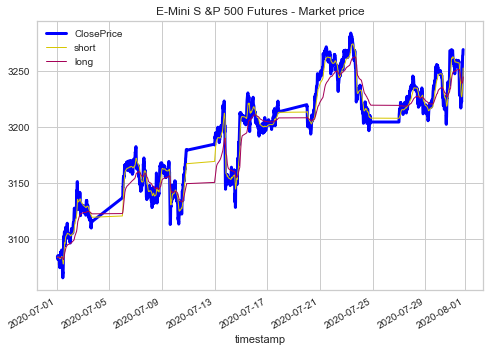

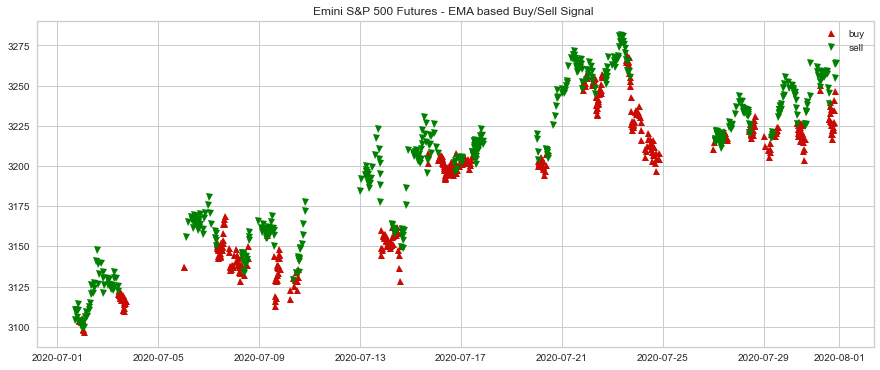

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

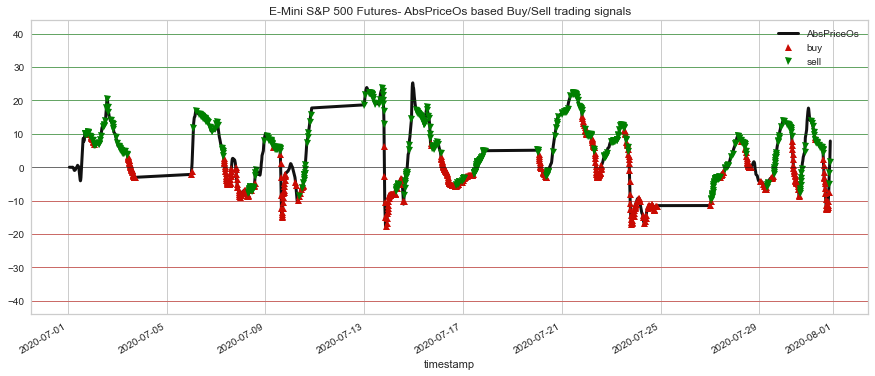

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

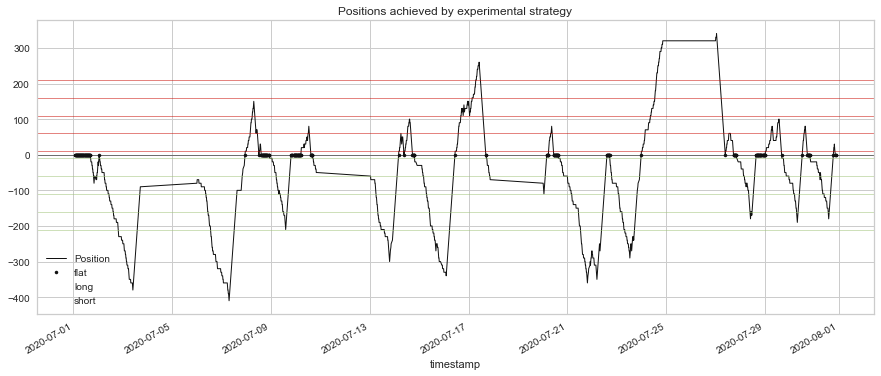

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

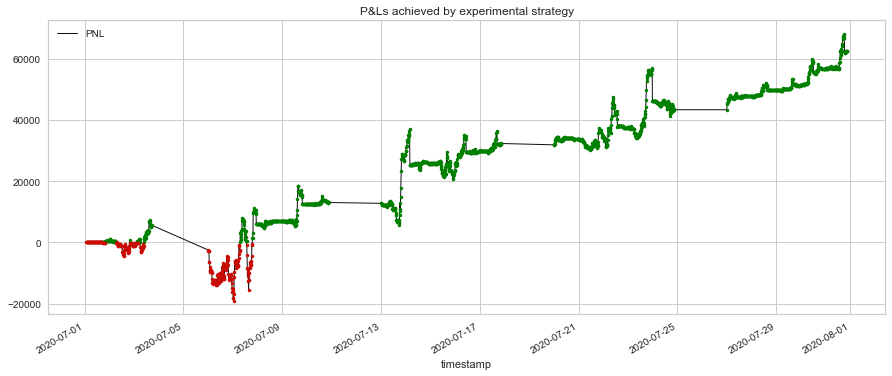

In [5]:
import statistics as stats
import math as math

print("@Sarit:")
# Variables/constants for EMA Calculation:
fast_period = 10 # Static time period parameter for the fast EMA
smooth_fast = 2 / (fast_period + 1) # Static smoothing factor parameter for fast EMA
ema_fast = 0
ema_fast_values = [] # we will hold fast EMA values for visualization purposes

slow_period = 40 # Static time period parameter for slow EMA
smooth_slow = 2 / (slow_period + 1) # Static smoothing factor parameter for slow EMA
ema_slow = 0
ema_slow_values = [] # we will hold slow EMA values for visualization purposes

apo_values = [] # track computed absolute price oscillator value signals

# Variables for Trading Strategy trade, position & pnl management:
orders = [] # Container for tracking buy/sell order, +1 for buy order, -1 for sell order, 0 for no-action
positions = [] # Container for tracking positions, +ve for long positions, -ve for short positions, 0 for flat/no position
pnls = [] # Container for tracking total_pnls, this is the sum of closed_pnl i.e. pnls already locked in and open_pnl i.e. pnls for open-position marked to market price

last_buy_price = 0 # Price at which last buy trade was made, used to prevent over-trading at/around the same price
last_sell_price = 0 # Price at which last sell trade was made, used to prevent over-trading at/around the same price
position = 0 # Current position of the trading strategy
buy_sum_price_qty = 0 # Summation of products of buy_trade_price and buy_trade_qty for every buy Trade made since last time being flat
buy_sum_qty = 0 # Summation of buy_trade_qty for every buy Trade made since last time being flat
sell_sum_price_qty = 0 # Summation of products of sell_trade_price and sell_trade_qty for every sell Trade made since last time being flat
sell_sum_qty = 0 # Summation of sell_trade_qty for every sell Trade made since last time being flat
open_pnl = 0 # Open/Unrealized PnL marked to market
closed_pnl = 0 # Closed/Realized PnL so far

# Constants that define strategy behavior/thresholds
apo_buy_enter = -10 # APO trading signal value below which to enter buy-orders/long-position
apo_sell_enter = 10 # APO trading signal value above which to enter sell-orders/short-position
min_price_movement_from_last_trade = 10 # Minimum price change since last trade before considering trading again, this is to prevent over-trading at/around same prices
num_stocks_per_trade = 10 # Number of shares to buy/sell on every trade
min_profit_to_close = 10 * num_stocks_per_trade # Minimum Open/Unrealized profit at which to close positions and lock profits

# Constants/variables that are used to compute standard deviation as a volatility measure
ma_periods = 20 # look back period
price_history = [] # history of prices

close = SPret['Close']
for close_price in close:
    price_history.append(close_price)
    if len(price_history) > ma_periods: # we track at most 'time_period' number of prices
        del (price_history[0])

    sma = stats.mean(price_history)
    variance = 0 # variance is square of standard deviation
    for hist_price in price_history:
        variance = variance + ((hist_price - sma) ** 2)

    stdev = math.sqrt(variance / len(price_history))
    stdev_factor = stdev/15
    if stdev_factor == 0:
        stdev_factor = 1

    # This section updates fast and slow EMA and computes APO trading signal
    if (ema_fast == 0): # first observation
        ema_fast = close_price
        ema_slow = close_price
    else:
        ema_fast = (close_price - ema_fast) * smooth_fast * stdev_factor + ema_fast
        ema_slow = (close_price - ema_slow) * smooth_slow * stdev_factor + ema_slow

    ema_fast_values.append(ema_fast)
    ema_slow_values.append(ema_slow)

    apo = ema_fast - ema_slow
    apo_values.append(apo)

    # This section checks trading signal against trading parameters/thresholds and positions, to trade.

    # We will perform a sell trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is above Sell-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are long( +ve position ) and either APO trading signal value is at or above 0 or current position is profitable enough to lock profit.
    if ((apo > apo_sell_enter * stdev_factor and abs(close_price - last_sell_price) > min_price_movement_from_last_trade * stdev_factor) 
        # APO above sell entry threshold, we should sell
        or
        (position > 0 and (apo >= 0 or open_pnl > min_profit_to_close / stdev_factor))): # long from -ve APO and APO has gone positive or position is profitable, sell to close position
        orders.append(-1) # mark the sell trade
        last_sell_price = close_price
        position -= num_stocks_per_trade # reduce position by the size of this trade
        sell_sum_price_qty += (close_price * num_stocks_per_trade) # update vwap sell-price
        sell_sum_qty += num_stocks_per_trade
        print( "SELL ", num_stocks_per_trade, " @ ", close_price, "Position => ", position )

    # We will perform a buy trade at close_price if the following conditions are met:
    # 1. The APO trading signal value is below Buy-Entry threshold and the difference between last trade-price and current-price is different enough.
    # 2. We are short( -ve position ) and either APO trading signal value is at or below 0 or current position is profitable enough to lock profit.
    elif ((apo < apo_buy_enter * stdev_factor and abs(close_price - last_buy_price) > \
           min_price_movement_from_last_trade * stdev_factor) # APO below buy entry threshold, we should buy
          or
          (position < 0 and (apo <= 0 or open_pnl > min_profit_to_close / stdev_factor))): # short from +ve APO and APO has gone negative or position is profitable, buy to close position
        orders.append(+1) # mark the buy trade
        last_buy_price = close_price
        position += num_stocks_per_trade # increase position by the size of this trade
        buy_sum_price_qty += (close_price * num_stocks_per_trade) # update the vwap buy-price
        buy_sum_qty += num_stocks_per_trade
        print( "BUY ", num_stocks_per_trade, " @ ", close_price, "POSITION: ", position ); print()
    else:
        # No trade since none of the conditions were met to buy or sell
        orders.append(0)

    positions.append(position)

    # This section updates Open/Unrealized & Closed/Realized positions
    open_pnl = 0
    if position > 0:
        if sell_sum_qty > 0: # long position and some sell trades have been made against it, close that amount based on how much was sold against this long position
            open_pnl = abs(sell_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
        
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(sell_sum_qty - position) * (close_price - buy_sum_price_qty / buy_sum_qty)
    elif position < 0:
        if buy_sum_qty > 0: # short position and some buy trades have been made against it, close that amount based on how much was bought against this short position
            open_pnl = abs(buy_sum_qty) * (sell_sum_price_qty/sell_sum_qty - buy_sum_price_qty/buy_sum_qty)
    
        # mark the remaining position to market i.e. pnl would be what it would be if we closed at current price
        open_pnl += abs(buy_sum_qty - position) * (sell_sum_price_qty/sell_sum_qty - close_price)
    else:
        # flat, so update closed_pnl and reset tracking variables for positions & pnls
        closed_pnl += (sell_sum_price_qty - buy_sum_price_qty)
        buy_sum_price_qty = 0
        buy_sum_qty = 0
        sell_sum_price_qty = 0
        sell_sum_qty = 0
        last_buy_price = 0
        last_sell_price = 0

    print( "Open/PnL-> ", open_pnl, " Closed/PnL-> ", closed_pnl, " Total/PnL-> ", (open_pnl + closed_pnl) ); print()
    pnls.append(closed_pnl + open_pnl)

# preparing the dataframe from the trading strategy results and visualizes the results
SPret = SPret.assign(ClosePrice = pd.Series(close, index = SPret.index))
SPret = SPret.assign(short = pd.Series(ema_fast_values, index = SPret.index))
SPret = SPret.assign(long = pd.Series(ema_slow_values, index = SPret.index))
SPret = SPret.assign(AbsPriceOs = pd.Series(apo_values, index = SPret.index))
SPret = SPret.assign(Trades = pd.Series(orders, index = SPret.index))
SPret = SPret.assign(Position = pd.Series(positions, index = SPret.index))
SPret = SPret.assign(PNL = pd.Series(pnls, index=SPret.index))

SPret['ClosePrice'].plot(color = 'blue', lw = 3., legend=True)
SPret['short'].plot(color ='y', lw = 1., legend=True)
SPret['long'].plot(color ='m', lw = 1., legend=True)
plt.title("E-Mini S &P 500 Futures - Market price")

plt.figure(figsize = (15, 6))
plt.plot(SPret.loc[SPret.Trades == 1 ].index, 
         SPret.ClosePrice[SPret.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(SPret.loc[ SPret.Trades == -1 ].index, 
         SPret.ClosePrice[SPret.Trades == -1 ], color='green', lw=0, marker='v', markersize=7, label='sell')
plt.legend()
plt.title('Emini S&P 500 Futures - EMA based Buy/Sell Signal ')
plt.show()

plt.figure(figsize = (15, 6))
SPret['AbsPriceOs'].plot(color='k', lw=3., legend=True)
plt.plot(SPret.loc[SPret.Trades == 1 ].index, 
         SPret.AbsPriceOs[SPret.Trades == 1 ], color='r', lw=0, marker='^', markersize=7, label='buy')
plt.plot(SPret.loc[ SPret.Trades == -1 ].index, 
         SPret.AbsPriceOs[SPret.Trades == -1 ], color='green', lw=0, marker='v', markersize=7, label='sell')
plt.axhline(y=0, lw=0.5, color='k')

for i in range( apo_buy_enter, apo_buy_enter * 5, apo_buy_enter ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range( apo_sell_enter, apo_sell_enter * 5, apo_sell_enter ):
    plt.axhline(y=i, lw=0.5, color='green')
plt.legend()
plt.title('E-Mini S&P 500 Futures- AbsPriceOs based Buy/Sell trading signals')
plt.show()

plt.figure(figsize = (15, 6))
SPret['Position'].plot(color='k', lw=1., legend=True)
plt.plot(SPret.loc[SPret.Position == 0 ].index, 
         SPret.Position[SPret.Position == 0 ], color='k', lw=0, marker='.', label='flat')
plt.plot(SPret.loc[SPret.Position > 1 ].index, 
         SPret.Position[SPret.Position > 1 ], color='r', lw=0, marker='+', label='long')
plt.plot(SPret.loc[SPret.Position < 1 ].index, 
         SPret.Position[SPret.Position < 1 ], color='green', lw=0, marker='_', label='short')
plt.axhline(y=0, lw=0.5, color='k')

for i in range(num_stocks_per_trade, num_stocks_per_trade * 25, num_stocks_per_trade * 5 ):
    plt.axhline(y=i, lw=0.5, color='r')
for i in range(- num_stocks_per_trade, - num_stocks_per_trade * 25, -num_stocks_per_trade * 5 ):
    plt.axhline(y=i, lw=0.5, color='g')
plt.legend()
plt.title('Positions achieved by experimental strategy')
plt.show()

plt.figure(figsize = (15, 6))
SPret['PNL'].plot(color='k', lw=1., legend=True)
plt.plot(SPret.loc[SPret.PNL > 1 ].index, SPret.PNL[SPret.PNL > 1 ], color='green', lw=0, marker='.')
plt.plot(SPret.loc[SPret.PNL < 1 ].index, SPret.PNL[SPret.PNL < 1 ], color='r', lw=0, marker='.')
plt.legend()
plt.title('P&Ls achieved by experimental strategy')
plt.show()

In [6]:
SPret = SPret.drop(['ClosePrice'],1)
SPret

,Close,Direction,SP_Returns,Predicted_Signal,Strategy_Returns,short,long,AbsPriceOs,Trades,Position,PNL
timestamp,,,,,,,,,,,
2020-07-01 01:30:00,3084.008333,1.0,NaN,-1.0,NaN,3084.008333,3084.008333,0.000000,0,0,0.000000
2020-07-01 01:45:00,3084.791667,1.0,0.000254,1.0,-0.000254,3084.012052,3084.009331,0.002721,0,0,0.000000
2020-07-01 02:00:00,3085.225000,1.0,0.000140,1.0,0.000140,3084.019455,3084.011322,0.008133,0,0,0.000000
2020-07-01 02:15:00,3083.933333,-1.0,-0.000419,1.0,-0.000419,3084.018890,3084.011184,0.007705,0,0,0.000000
2020-07-01 02:30:00,3082.208333,-1.0,-0.000560,-1.0,-0.000560,3083.996217,3084.005127,-0.008910,0,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-31 19:45:00,3254.658333,1.0,0.002428,1.0,0.002428,3234.535668,3239.691675,-5.156007,-1,20,62289.916667
2020-07-31 20:00:00,3263.591667,1.0,0.002741,1.0,0.002741,3238.864758,3240.647036,-1.782278,-1,10,62607.666667
2020-07-31 20:30:00,3264.100000,1.0,0.000156,1.0,0.000156,3243.149971,3241.715529,1.434442,-1,0,62612.750000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

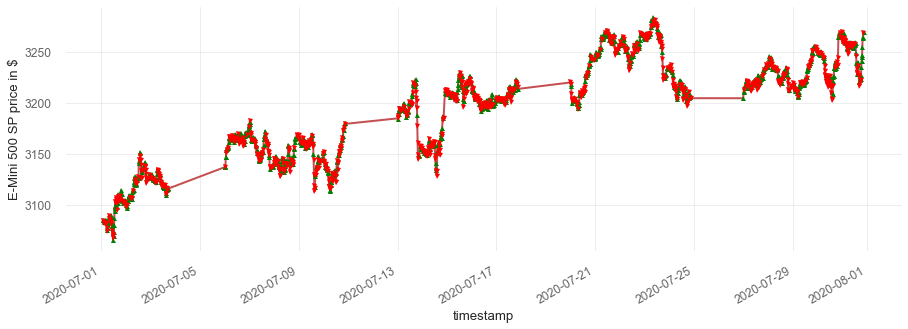

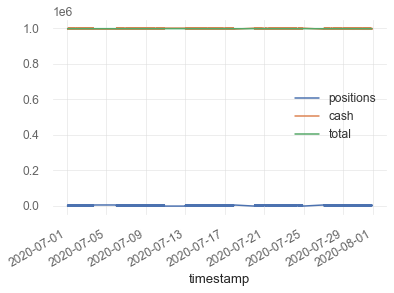

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

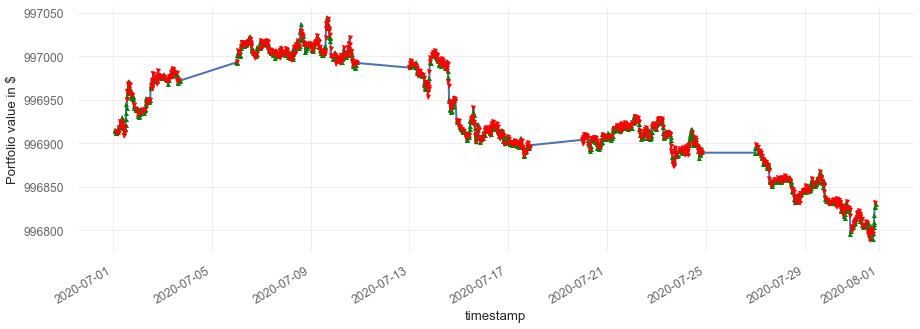

In [28]:
SPret['positions'] = SPret['Predicted_Signal'].diff()
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(111, ylabel='E-Mini 500 SP price in $')
SPret['Close'].plot(ax=ax1, color='r', lw=2.)

ax1.plot(SPret.loc[SPret.Predicted_Signal == 1.0].index,
         SPret.Close[SPret.Predicted_Signal == 1.0],
         '^', markersize=5, color='green')

ax1.plot(SPret.loc[SPret.Predicted_Signal == -1.0].index,
         SPret.Close[SPret.Predicted_Signal == -1.0],
         'v', markersize=5, color='red')

# Set the initial capital
initial_capital= float(1000000.0)

positions = DataFrame(index=SPret.index).fillna(0.0)
portfolio = DataFrame(index=SPret.index).fillna(0.0)

#fig = plt.figure(figsize = (15,5))
positions['SP'] = SPret['Predicted_Signal']
portfolio['positions'] = (positions.multiply(SPret['Close'], axis=0))
portfolio['cash'] = initial_capital - (positions.diff().multiply(SPret['Close'], axis=0)).cumsum()
portfolio['total'] = portfolio['positions'] + portfolio['cash']
portfolio.plot()
plt.show()


fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
portfolio['total'].plot(ax=ax1, lw=2.)
ax1.plot(portfolio.loc[SPret.Predicted_Signal == 1.0].index, 
         portfolio.total[SPret.Predicted_Signal == 1.0],'^', markersize=5, color='green')
ax1.plot(portfolio.loc[SPret.Predicted_Signal == -1.0].index,
         portfolio.total[SPret.Predicted_Signal == -1.0],'v', markersize=5, color='red')
plt.show()

In [8]:
SPret.to_csv("SP_backtest_experimental.csv", sep=",")

In [9]:
pip install QuantStats

Note: you may need to restart the kernel to use updated packages.


In [10]:
import quantstats as qs

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
stock = SPret.SP_Returns

# show sharpe ratio
qs.stats.sharpe(stock)

# or using extend_pandas() :)
stock.sharpe()

0.4772965910830379

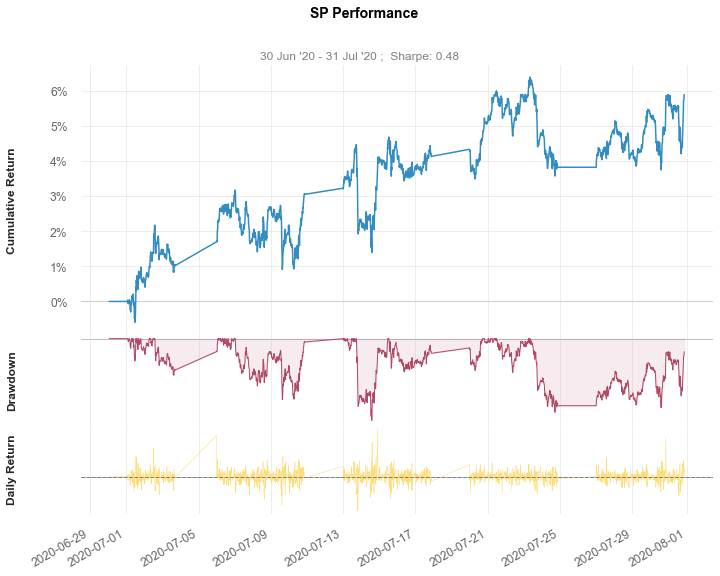

In [11]:
qs.plots.snapshot(stock, title='SP Performance')

# can also be called via:
# stock.plot_snapshot(title='Facebook Performance')

In [12]:
qs.reports.metrics(stock)

                    Strategy
------------------  ----------
Start Period        2020-07-01
End Period          2020-07-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   5.9%
CAGR%               100.79%
Sharpe              0.48
Sortino             0.7
Max Drawdown        -2.95%
Longest DD Days     8

Payoff Ratio        1.01
Profit Factor       1.09
Common Sense Ratio  1.15
CPC Index           0.57
Tail Ratio          1.05
Outlier Win Ratio   3.75
Outlier Loss Ratio  4.1

MTD                 5.9%
3M                  5.9%
6M                  5.9%
YTD                 5.9%
1Y                  5.9%
3Y (ann.)           100.79%
5Y (ann.)           100.79%
10Y (ann.)          100.79%
All-time (ann.)     100.79%

Avg. Drawdown       -0.35%
Avg. Drawdown Days  0
Recovery Factor     2.0
Ulcer Index         1.02


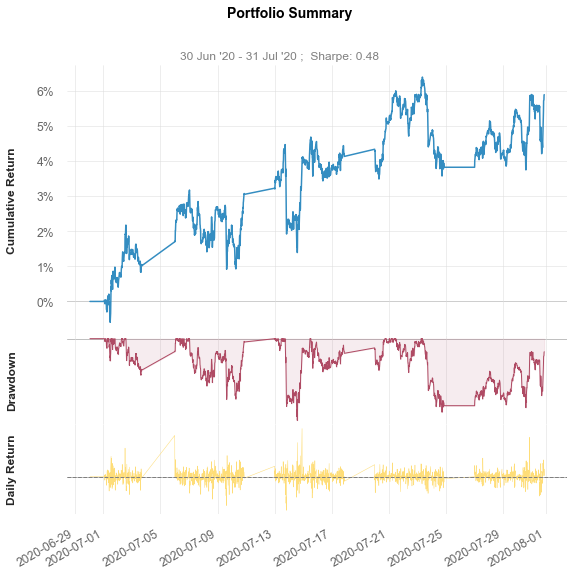

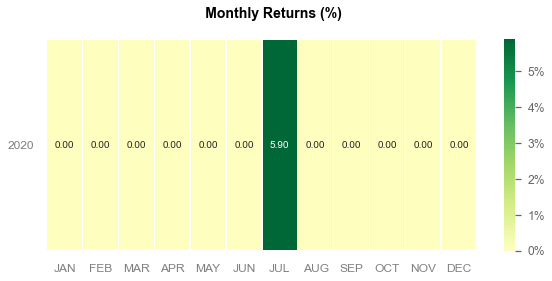

In [13]:
qs.reports.plots(stock)

                           Strategy
-------------------------  ----------
Start Period               2020-07-01
End Period                 2020-07-31
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          5.9%
CAGR%                      100.79%
Sharpe                     0.48
Sortino                    0.7
Max Drawdown               -2.95%
Longest DD Days            8
Volatility (ann.)          1.51%
Calmar                     34.2
Skew                       0.38
Kurtosis                   6.93

Expected Daily %           0.0%
Expected Monthly %         5.9%
Expected Yearly %          5.9%
Kelly Criterion            4.32%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.15%
Expected Shortfall (cVaR)  -0.15%

Payoff Ratio               1.01
Profit Factor              1.09
Common Sense Ratio         1.15
CPC Index                  0.57
Tail Ratio                 1.05
Outlier Win Ratio          3.75
Outlier Loss Ratio         4.1

MTD   

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-07-13,2020-07-14,2020-07-15,1,-2.947352,-2.802380
2,2020-07-23,2020-07-24,2020-07-31,8,-2.652380,-2.454319
3,2020-07-07,2020-07-09,2020-07-13,5,-2.189371,-2.092010
4,2020-07-02,2020-07-03,2020-07-06,3,-1.314638,-1.295055
5,2020-07-21,2020-07-22,2020-07-23,1,-1.218024,-1.124255


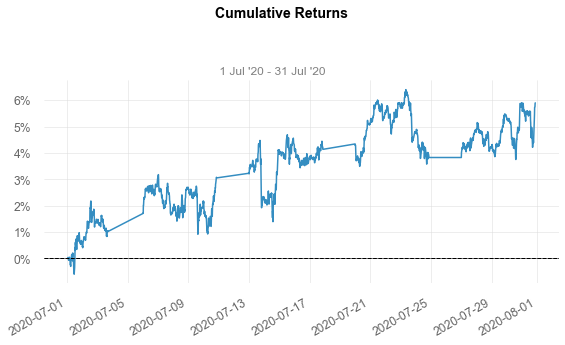

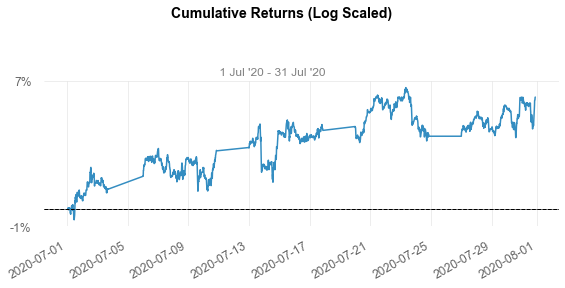

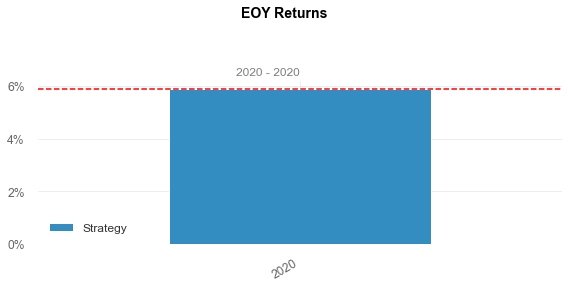

C:\Users\Sarit\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Sarit\anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


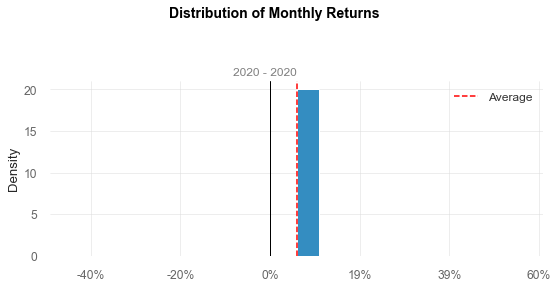

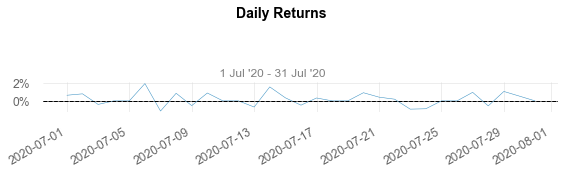

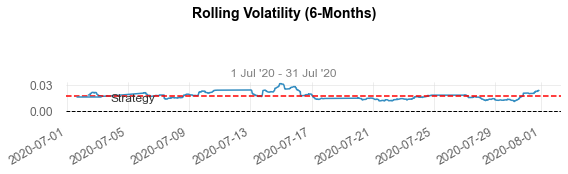

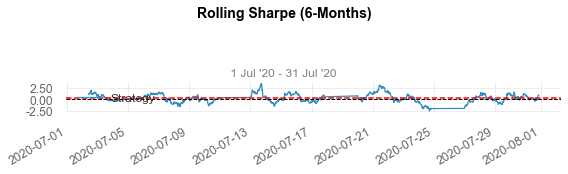

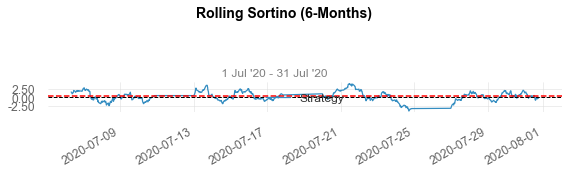

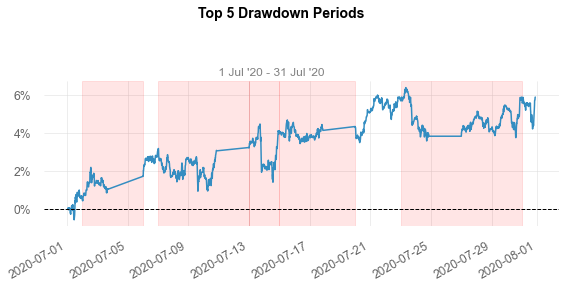

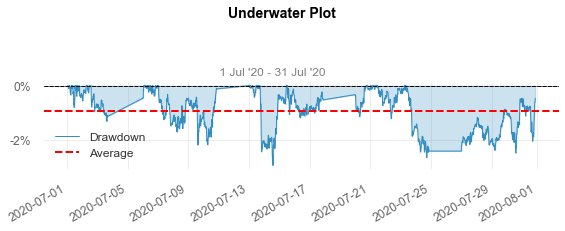

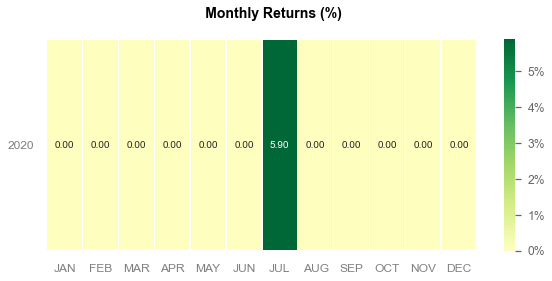

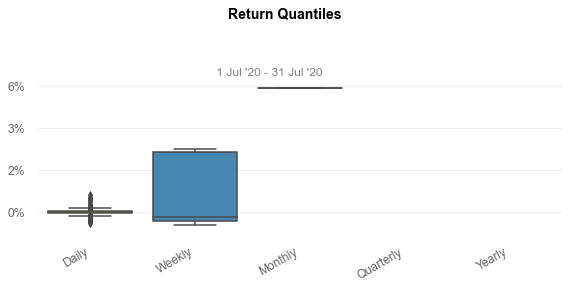

In [16]:
qs.reports.full(stock)

In [15]:
# Number of features
n = 1000
# Number of training examples
m = 10000
# Initialize X and W
X = np.random.rand(n,m)
W = np.random.rand(n,1)

# Vectorized code
t1=time.time()
Z = np.dot(W.T,X)
print("Time taken for vectorized code is : ",(time.time()-t1)*1000,"ms")

# Loop code
Z1 = np.zeros((1,m))
t2 = time.time()
for i in range(X.shape[1]):
    for j in range(X.shape[0]):
        Z[0][i] += W[j]*X[j][i]
print("Time taken for Loop code is : ",(time.time()-t2)*1000,"ms")

Time taken for vectorized code is :  3.992319107055664 ms
Time taken for Loop code is :  41600.73733329773 ms
